# Multi-scale Gaussian filters

In [1]:
import math
import matplotlib.pyplot as plt
import nibabel
import numpy as np
from numpy.fft import fftn, ifftn, fftshift, ifftshift

% matplotlib inline
plt.style.use('seaborn-white')

GOLDEN_RATIO = (1.0 + math.sqrt(5.0)) / 2.0

def gaussian_1d(x, mu=0.0, sigma=1.0, normalize=True):
    """Gaussian
    
    returns Gaussian evaluated at x
    """
    
    if normalize:
        a = 1.0/sigma/np.sqrt(2.0*np.pi)
    else:
        a = 1.0

    g = a * np.exp(-0.5/sigma**2 * (x-mu)**2)

    return g
    
def gaussian_1d_scaled(x, W=1.0, scale=1):
    """Scaled Gaussian parametrized by window and scale
    
    returns unnormalized Gaussian evaluated at x
    
    Scale 0 fits in -W/2, W/2
    Scale 1 fits in -W/4, W/4
    Scale 2 fits in -W/8, W/8
    """
    sigma = W / (2.0*math.pi) / 2**scale
    g = gaussian_1d(x, mu=0.0, sigma=sigma, normalize=False)

    return g, sigma


def gaussian_filter(data, scale=1, truncate=True):
    """Rotationally symmetric Gaussian filter in the fourier domain
    """
    
    if data.ndim < 2 or data.ndim > 3:
        raise RuntimeError('Unsupported number of dimensions {}.  We only supports 2 or 3D arrays.'.format(data.ndim))

    # Build the filter in the fourier domain
    if data.ndim == 2:
        nx, ny = data.shape
        fx, fy = np.meshgrid(np.linspace(-nx/2, nx/2, nx), np.linspace(-ny/2, ny/2, ny), indexing='ij')
        sx = nx / (2.0*math.pi) / 2**scale
        sy = ny / (2.0*math.pi) / 2**scale
        rsq = (fx/sx)**2 + (fy/sy)**2

    else:
        nx, ny, nz = data.shape
        fx, fy, fz = np.meshgrid(np.linspace(-nx/2, nx/2, nx),
                                 np.linspace(-ny/2, ny/2, ny),
                                 np.linspace(-nz/2, nz/2, nz),
                                 indexing='ij')
        sx = nx / (2.0*math.pi) / 2**scale
        sy = ny / (2.0*math.pi) / 2**scale
        sz = nz / (2.0*math.pi) / 2**scale
        rsq = (fx/sx)**2 + (fy/sy)**2 + (fz/sz)**2

    g = np.exp(-0.5*rsq)

    # Truncate on a sphere of r=pi^2
    if truncate:
        g[rsq > math.pi**2] = 0.0

    output = ifftn(ifftshift(g*fftshift(fftn(data))))

    if np.isrealobj(data):
        return np.real(output)
    else:
        return output

## Gaussians at multiple scales

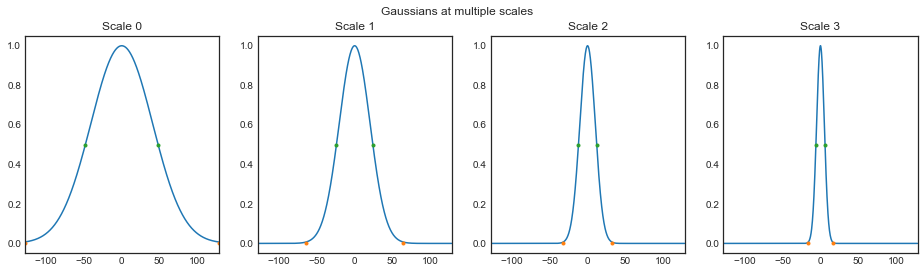

In [2]:
# Number of points in the frequency domain
Nf = 256

# The locations at which to evaluate the gaussian
# oversampled to make the plots prettier
x = np.linspace(-Nf/2, Nf/2, 4*Nf)

# Evaluate the Gaussian at several levels
nscales = 4
scales = range(nscales)

fig, axes = plt.subplots(nrows=1, ncols=nscales)
fig.set_size_inches(4*nscales,4)
plt.suptitle('Gaussians at multiple scales')
for ax, s in zip(axes.flat[:], scales):
    # Gaussian at scale s
    g, sigma = gaussian_1d_scaled(x, W=Nf, scale=s)
    # The cutoff is approximately W * (1/2)^s
    c = Nf/2*(1/2)**s
    # The half width at half max
    hw = sigma * math.sqrt(2*math.log(2))
    ax.plot(x, g)
    ax.plot([-c, c],   [0.0, 0.0], '.')
    ax.plot([-hw, hw], [0.5, 0.5], '.')
    ax.set_title('Scale {}'.format(s))
    ax.set_xlim(-Nf/2,Nf/2)


## Difference of two Gaussians one scale level apart

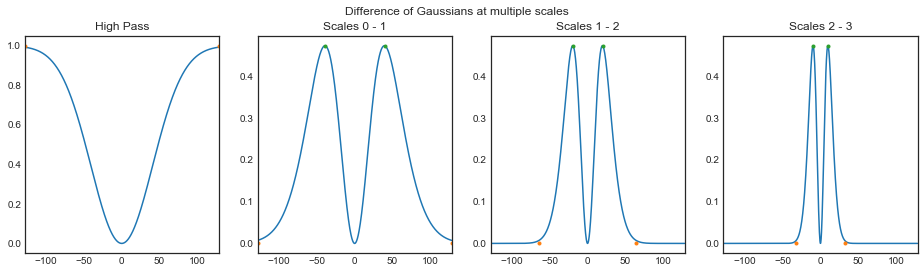

In [3]:
# For differences of two gaussians one at scale s and the other at scale s+1,
# the maximum occurs halfway between the two cutoffs in a geometric mean sense
# W/2*(1/2)**(s+1) * (golden_ratio - 1.0) with a value of exp(-3/4)
b = GOLDEN_RATIO - 1.0
a = math.exp(-3/4)

fig, axes = plt.subplots(nrows=1, ncols=nscales)
fig.set_size_inches(4*nscales,4)
plt.suptitle('Difference of Gaussians at multiple scales')

# The high pass filter is special, 1 - gaussian at scale 0
g0,  sigma  = gaussian_1d_scaled(x, W=Nf, scale=0)
axes[0].plot(x, 1.0-g0)
c = Nf/2
axes[0].plot([-c, c], [1.0, 1.0], '.')
axes[0].set_xlim(-Nf/2,Nf/2)
axes[0].set_title('High Pass')

# Loop over the pairs s and s+1
for ax, s in zip(axes.flat[1:], scales[:-1]):
    # Gaussian at scale s and s+1, t
    gs,  sigma  = gaussian_1d_scaled(x, W=Nf, scale=s)
    gsp, sigmap = gaussian_1d_scaled(x, W=Nf, scale=s+1)
    c = Nf/2*(1/2)**s
    cp = Nf/2*(1/2)**(s+1)
    ax.plot(x, gs - gsp)
    ax.plot([-c, c],   [0.0, 0.0], '.')
    ax.plot([-b*cp, b*cp], [a, a], '.')
    ax.set_title('Scales {} - {}'.format(s, s+1))
    ax.set_xlim(-Nf/2,Nf/2)


## Gaussian filtering of an image

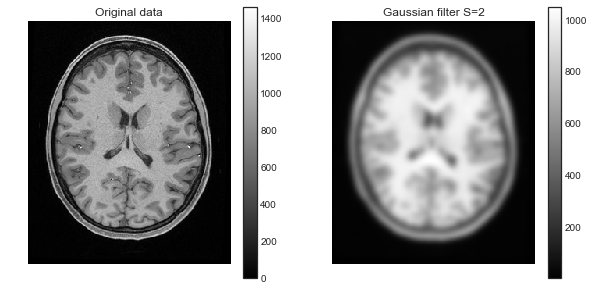

In [4]:
# Load some brain data
t1 = nibabel.load('data/HCP/100307/T1w_acpc_dc_restore.nii.gz').get_data()
# Select a single slice, convert to double and flip around so that it looks right side up
z = 120
data = t1.astype(np.double)[:,::-1,z].transpose()

# Apply a Gaussian filter at a scale of 2
g_data = gaussian_filter(data, scale=2)

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(data, cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Original data')

plt.subplot(1,2,2)
plt.imshow(g_data, cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Gaussian filter S=2')


# Pyramids

In [5]:
# Generate a sequence of images filtered with a gaussian at different scales
nscales = 4
scales = range(nscales)

gdata_0 = gaussian_filter(data, scale=0)
gdata_1 = gaussian_filter(data, scale=1)
gdata_2 = gaussian_filter(data, scale=2)
gdata_3 = gaussian_filter(data, scale=3)

## Gaussian Pyramid

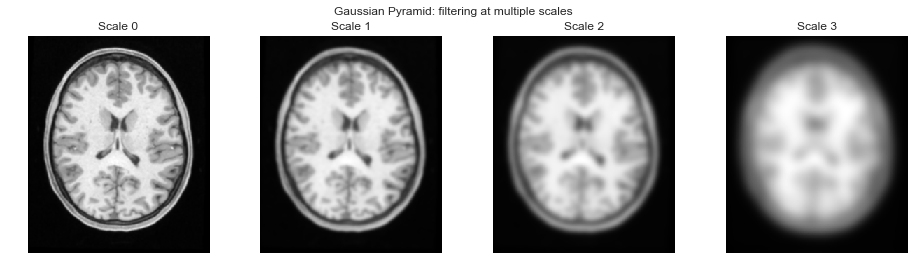

In [6]:
plt.figure(figsize=[16,4])
plt.suptitle('Gaussian Pyramid: filtering at multiple scales')
plt.subplot(1,4,1)
plt.imshow(gdata_0, cmap='gray')
plt.axis('off')
plt.title('Scale 0')
plt.subplot(1,4,2)
plt.imshow(gdata_1, cmap='gray')
plt.axis('off')
plt.title('Scale 1')
plt.subplot(1,4,3)
plt.imshow(gdata_2, cmap='gray')
plt.axis('off')
plt.title('Scale 2')
plt.subplot(1,4,4)
plt.imshow(gdata_3, cmap='gray')
plt.axis('off')
plt.title('Scale 3')

## Laplacian Pyramid

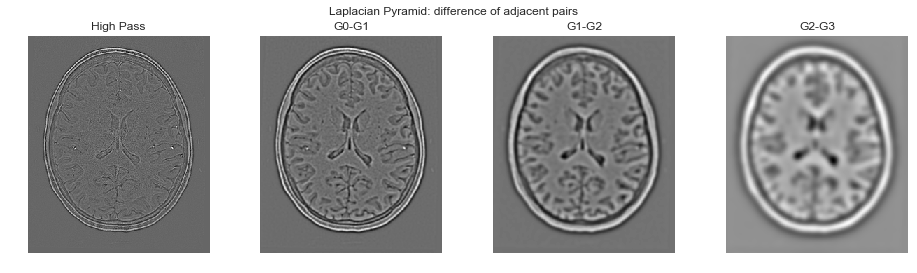

In [7]:
plt.figure(figsize=[16,4])
plt.suptitle('Laplacian Pyramid: difference of adjacent pairs')
plt.subplot(1,4,1)
plt.imshow(data-gdata_0, cmap='gray')
plt.axis('off')
plt.title('High Pass')
plt.subplot(1,4,2)
plt.imshow(gdata_0 - gdata_1, cmap='gray')
plt.axis('off')
plt.title('G0-G1')
plt.subplot(1,4,3)
plt.imshow(gdata_1 - gdata_2, cmap='gray')
plt.axis('off')
plt.title('G1-G2')
plt.subplot(1,4,4)
plt.imshow(gdata_2 - gdata_3, cmap='gray')
plt.axis('off')
plt.title('G2-G3')

## This also works in 3D

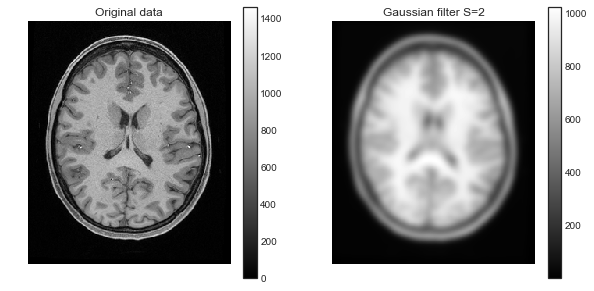

In [10]:
data = t1.astype(np.double)

# Apply a Gaussian filter at a scale of 2
g_data = gaussian_filter(data, scale=2)

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(data[:,::-1,z].transpose(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Original data')

plt.subplot(1,2,2)
plt.imshow(g_data[:,::-1,z].transpose(), cmap='gray')
plt.axis('off')
plt.colorbar()
plt.title('Gaussian filter S=2')